In [1]:
import os, cv2, itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#!pip install np_utils

from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.utils import shuffle

import sklearn
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

In [2]:
TRAIN_DIR = './train/'
TEST_DIR = './test/'

ROWS = 64
COLS = 64
CHANNELS = 3

In [3]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [4]:
def read_image(file_path):
  #print(file_path)
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  #print(img)
  return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [5]:
def prep_data(images):
  m = len(images)
  n_x = ROWS*COLS*CHANNELS
  
  X = np.ndarray((m,ROWS,COLS,CHANNELS), dtype=np.uint8)
  y = np.zeros((m,1))
  print("X.shape is {}".format(X.shape))
  
  for i,image_file in enumerate(images) :
    image = read_image(image_file)
    X[i,:] = np.squeeze(image.reshape((ROWS, COLS, CHANNELS)))
    if 'dog' in image_file.lower() :
      y[i,0] = 1
    elif 'cat' in image_file.lower() :
      y[i,0] = 0
    else : # for test data
      y[i,0] = image_file.split('/')[-1].split('.')[0]
      
    if i%5000 == 0 :
      print("Proceed {} of {}".format(i, m))
    
  return X,y

In [6]:
X_train, y_train = prep_data(train_images)
X_test, test_idx = prep_data(test_images)

X.shape is (25000, 64, 64, 3)
Proceed 0 of 25000
Proceed 5000 of 25000
Proceed 10000 of 25000
Proceed 15000 of 25000
Proceed 20000 of 25000
X.shape is (12500, 64, 64, 3)
Proceed 0 of 12500
Proceed 5000 of 12500
Proceed 10000 of 12500


In [7]:
print("Train shape: {}".format(X_train.shape))
print("Test shape: {}".format(X_test.shape))

Train shape: (25000, 64, 64, 3)
Test shape: (12500, 64, 64, 3)


In [8]:
X_train, y_train = shuffle(X_train, y_train)


In [9]:
classes = {0: 'cats',
           1: 'dogs'}

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print("Train shape: {}".format(X_train.shape))
print("Train label shape: {}".format(y_train.shape))
print("Validation shape: {}".format(X_val.shape))
print("Validation label shape: {}".format(y_val.shape))

Train shape: (20000, 64, 64, 3)
Train label shape: (20000, 1)
Validation shape: (5000, 64, 64, 3)
Validation label shape: (5000, 1)


In [11]:
y_train_one_hot = to_categorical(y_train)
print(y_train_one_hot.shape)

num_classes = y_train_one_hot.shape[1]
print(num_classes)

y_val_one_hot = to_categorical(y_val)
print(y_val_one_hot.shape)

(20000, 2)
2
(5000, 2)


In [12]:
def show_images(X, y, idx) :
  image = X[idx]
  #image = image.reshape((ROWS, COLS, CHANNELS))
  plt.figure(figsize=(4,2))
  plt.imshow(image)
  plt.title("This is a {}".format(classes[y[idx,0]]))
  plt.show()

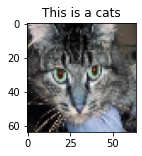

In [13]:
show_images(X_train, y_train, 0)

In [14]:
X_train_norm = X_train / 255
X_val_norm = X_val / 255

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
from keras.optimizers import SGD
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(ROWS, COLS, CHANNELS), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (1,1), activation='relu'))
#model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))
sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)

model.compile( loss = "categorical_crossentropy",  optimizer = sgd,   metrics=['accuracy'] )
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
__________

In [17]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="val_loss", patience=2),
ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
model.fit(X_train_norm, y_train_one_hot, validation_data=(X_val_norm, y_val_one_hot), epochs=50, batch_size = 10)


Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 162s 8ms/step - loss: 0.6868 - acc: 0.5419 - val_loss: 0.6959 - val_acc: 0.5294
Epoch 2/50
20000/20000 [==============================] - 164s 8ms/step - loss: 0.6507 - acc: 0.6189 - val_loss: 0.6302 - val_acc: 0.6656
Epoch 3/50
20000/20000 [==============================] - 165s 8ms/step - loss: 0.6112 - acc: 0.6677 - val_loss: 0.5596 - val_acc: 0.7196
Epoch 4/50
20000/20000 [==============================] - 163s 8ms/step - loss: 0.5666 - acc: 0.7071 - val_loss: 0.5363 - val_acc: 0.7348
Epoch 5/50
20000/20000 [==============================] - 164s 8ms/step - loss: 0.5275 - acc: 0.7410 - val_loss: 0.5572 - val_acc: 0.7086
Epoch 6/50
20000/20000 [==============================] - 162s 8ms/step - loss: 0.4906 - acc: 0.7662 - val_loss: 0.5576 - val_acc: 0.7258
Epoch 7/50
20000/20000 [==============================] - 163s 8ms/step - loss: 0.4654 - acc: 0.7802 - val_loss: 0.4469 - v

In [ ]:
model.save("model2.h5")
print("Saved model to disk")

image = X_train[0]
test_pred = model.predict_classes(image.reshape(1, 64, 64, 3))

show_images(X_train, y_train,0)

print("Our Model Prediction: {}".format(test_pred))

In [ ]:
image = X_train[100]
test_pred = model.predict_classes(image.reshape(1, 64, 64, 3))

show_images(X_train, y_train,100)

print("Our Model Prediction: {}".format(test_pred))

In [ ]:
def show_image_prediction(X, idx, model) :
  image = X[idx].reshape(1,64,64,3)
  image_class = classes[model.predict_classes(image).item()]
  image = image.reshape((ROWS, COLS, CHANNELS))
  plt.figure(figsize = (4,2))
  plt.imshow(image)
  plt.title("Test {} : I think this is {}".format(idx, image_class))
  plt.show()

In [ ]:
X_test_lr, test_idx = X_test, test_idx

for i in np.random.randint(0, len(X_test_lr), 10) :
  show_image_prediction(X_test_lr, i, model)